# DATA COLLECTION

## 1. Collect and label image data

In [1]:
import os 
import time
import uuid     # To create nique uniform identifier for collected images
import cv2      # For access camera sensors for image data collection

### 1.1 Collect the image data

In [2]:
IMAGES_PATH = os.path.join('data','train','images')
number_images = 30

In the code block below, we will capture a number of images from the camera. There will be a little delay between each image capture for the user to make slight adjustment to their faces and postures.

In [3]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_EXPOSURE,-6)

for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    
    ret, frame = cap.read()

    if not ret:
        print("There are some errors in the capture process")
        break

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('Frame', frame)
    time.sleep(1.0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

There are some errors in the capture process


### 1.2 Label the image data

In [4]:
!labelme 

'labelme' is not recognized as an internal or external command,
operable program or batch file.


## 2. Review Dataset and Build Image Loading Function 

### 2.1 Import TF and dependencies

In [5]:
import tensorflow as tf 
import json         # For parsing the json label files
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'{len(gpus)} GPUs found')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1 GPUs found


### 2.3 Load Image in to TF Data Pipeline

In this section, we will use the function ```tf.data.Dataset.list_files()``` ([Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files)) to load the jpg files in a directory. The first argument of this function is the file path/pattern that we are looking for, while the second argument specifies that there should be no data shuffling. This function returns a Dataset of type ```tensorflow.python.data.ops.dataset_ops.TensorSliceDataset```

In [50]:
images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg',shuffle=False)
type(images.as_)

tensorflow.python.data.ops.dataset_ops._NumpyIterator

In [8]:
images.take(1)

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [9]:
images.as_numpy_iterator().next()

b'data\\train\\images\\28b03f66-e98b-11ef-8d00-4cd717a70326.jpg'

Helper function to load the images from the file path into an image generator object. This function first read the byte-encoded images and convert them to array of image pixel values.

This function is later [mapped]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map)) on to the generator with the image path to load the images

In [10]:
def load_image(x):
    '''Function to load image from file path. This function reads the byte data from the file path and decodes it into an image tensor'''
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
# Look at one image sample and its shape
print('Image pixel values \n',images.as_numpy_iterator().next())
print('\nImage shape ', images.as_numpy_iterator().next().shape)

Image pixel values 
 [[[242 249 241]
  [242 249 241]
  [242 250 239]
  ...
  [235 238 229]
  [237 238 230]
  [237 237 229]]

 [[241 248 240]
  [242 249 241]
  [242 250 239]
  ...
  [232 238 228]
  [235 236 228]
  [234 234 226]]

 [[238 248 239]
  [239 249 240]
  [240 250 241]
  ...
  [233 243 232]
  [238 241 234]
  [242 241 236]]

 ...

 [[231 248 240]
  [230 247 239]
  [228 245 239]
  ...
  [222 234 222]
  [219 230 216]
  [215 226 212]]

 [[228 247 241]
  [227 246 240]
  [225 244 238]
  ...
  [227 237 226]
  [222 233 219]
  [218 229 215]]

 [[227 246 240]
  [226 245 239]
  [225 244 238]
  ...
  [231 241 230]
  [227 238 224]
  [224 235 221]]]

Image shape  (480, 640, 3)


In [13]:
type(images)  # This is a tensorflow dataset object 

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 Display raw data with Matplotlib

Group the images in the generator into small batches of 4 images => [Data batching]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map))

In [14]:
image_generator = images.batch(4).as_numpy_iterator()    # Batch the images into batches of 4

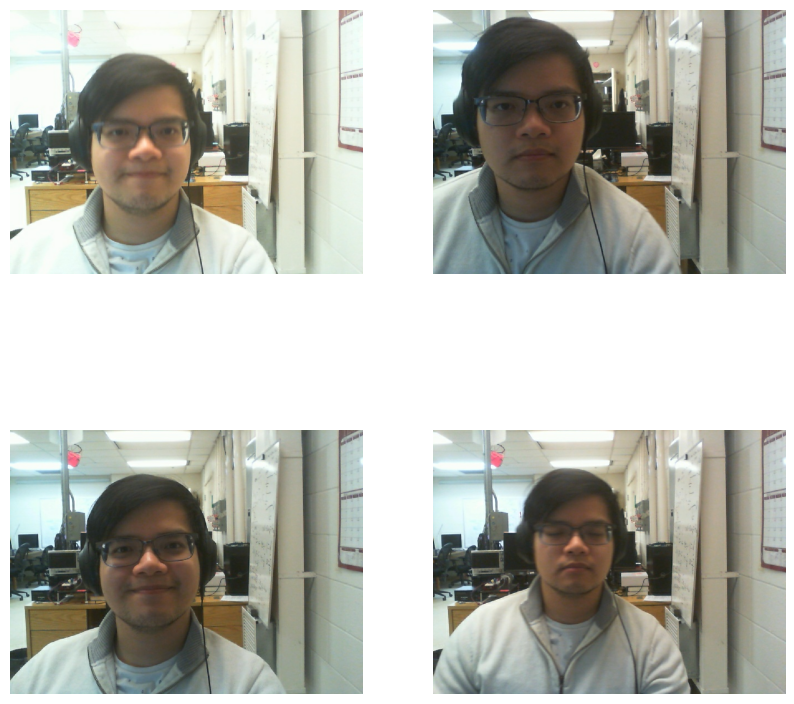

In [15]:
plot_images = image_generator.next()    # Get the next batch of images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for idx, image in enumerate(plot_images):
    ax[idx%2, idx//2].imshow(image)
    ax[idx%2, idx//2].axis('off')

plt.show()

# DATA PROCESSING AND AUGMENTATION

## 3. Partition Unaugmented Data

### 3.1 Moving the images into corresponding directories
The following functions are responsible for randomly splitting the image data according to the desired train/validation/test split

In [16]:
import random

def count_images(directories):
    """
    Function to count the number of images in a list of directories
    """
    return [len(tf.io.gfile.glob(os.path.join(directory, '*.jpg'))) for directory in directories]

def move_images(source_dir, target_dir, num_images):
    """
    Function to move images from one directory to another
    """
    images = tf.io.gfile.glob(os.path.join(source_dir, '*.jpg'))        # List of image paths in the source directory
    random.shuffle(images)
    for image_path in images[:num_images]:
        filename = os.path.basename(image_path)                         # Get the filename    
        target_path = os.path.join(target_dir, filename)                # Create the target path
        tf.io.gfile.copy(image_path, target_path, overwrite=True)       # Copy the image to the target path
        tf.io.gfile.remove(image_path)                                  # Remove the image from the source directory

def data_split(train_dir, val_dir, test_dir, desired_train=0.8, desired_val=0.2, seed=42):
    """
    Function to split the data (both images and labels) into training, validation, and possibly testing sets
    """
    # Calculate the proportion of images for training, validation, and testing
    total_proportion = desired_train + desired_val
    if total_proportion > 1:
        raise ValueError('The sum of desired_train and desired_val must not exceed 1')
    else:
        desired_test = 1 - total_proportion

    train_img_dir = os.path.join(train_dir, 'images')
    # Ensure the validation image directory exists
    val_img_dir = os.path.join(val_dir, 'images')
    os.makedirs(val_img_dir, exist_ok=True)
    # Ensure the test image directory exists (if provided)
    test_img_dir = os.path.join(test_dir, 'images')
    os.makedirs(test_img_dir, exist_ok=True)

    # Find the current number of images in train, val, and test
    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])
    total_images = train_count + val_count + test_count

    # Find the desired number of images in train, val, and test
    desired_train_count = int(total_images * desired_train)
    desired_val_count = int(total_images * desired_val) if desired_test else total_images - desired_train_count
    desired_test_count = total_images - desired_train_count - desired_val_count if desired_test else 0
    
    # Moving images between validation and test directories, then recount the images
    if val_count > desired_val_count:
        move_images(val_img_dir, test_img_dir, val_count - desired_val_count)
    elif val_count < desired_val_count:
        move_images(test_img_dir, val_img_dir, desired_val_count - val_count)

    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])

    # Moving the images between the training and test directories
    if test_count > desired_test_count:
        move_images(test_img_dir, train_img_dir, test_count - desired_test_count)
    elif test_count < desired_test_count:
        move_images(train_img_dir, test_img_dir, desired_test_count - test_count)

    # Find the current number of images in train, val, and test after the shift
    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])

    return train_count, val_count, test_count

In [17]:
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

data_split(train_dir, val_dir, test_dir, 
           desired_train=0.8, 
           desired_val=0.1)

(26, 3, 4)

### 3.2 Move the corresponding labels

The code block below goes into each images directory in {train/test/val} and look at each jpg file. It then looks at the corresponding json file with the matching name in the data\\train\\labels directory and move them to the train/test/val images directory

1. Goes into each directory train, test, and val (the first for loop)
2. Goes into each jpg file in the images directory (the second for loop)
3. Replaces the .jpg extension with the .json extension for each filename. If there is an existing file path of the file in data\\train\\labels, replace that file path with one that resides in the corresponding labels folder

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder,'images')):
        filename = file.split('.')[0]+'.json'                               # JSON file of the label
        existing_filepath = os.path.join('data','train','labels',filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## 4. Introduction to Albumentations for Image & Labels Augmentation 
This section is an introduction to using Albumentation to augment one image and the bounding boxes. We will only work with one test image for this section before moving on to performing augmentation with all images in the next section

### 4.1 Set up Albumentations


[Document for bounding box augmentation](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)

In [19]:
import albumentations as alb

In [20]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.VerticalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2)],
                         bbox_params = alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [21]:
image_test = cv2.imread(os.path.join('data','train','images','8564026f-e98b-11ef-9917-4cd717a70326.jpg'))

with open(os.path.join('data','train','labels','8564026f-e98b-11ef-9917-4cd717a70326.json'),'r') as f:
    label = json.load(f)            # Load the json file. The file is formatted as a dictionary

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

We will load a random image from the training set and the corresponding bounding box information from the json file

In [22]:
image_test = cv2.imread(os.path.join('data','train','images','8564026f-e98b-11ef-9917-4cd717a70326.jpg'))

with open(os.path.join('data','train','labels','8564026f-e98b-11ef-9917-4cd717a70326.json'),'r') as f:
    label = json.load(f)            # Load the json file. The file is formatted as a dictionary

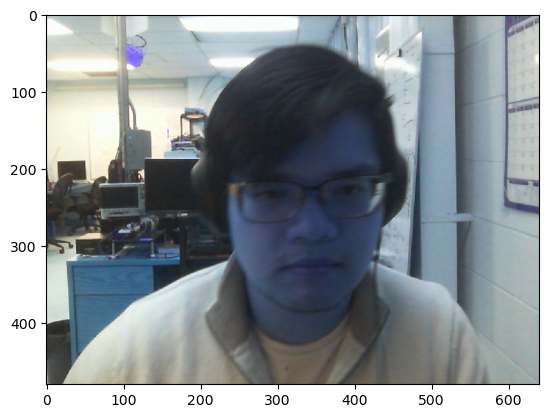

In [23]:
plt.imshow(image_test)

In [24]:
# Extract the bounding box coordinates and class labels from the json file
print('Detected label(s): ',label['shapes'][0]['label'])
print('Coordinates of the bounding box: ',label['shapes'][0]['points'])

Detected label(s):  face
Coordinates of the bounding box:  [[215.94594594594597, 138.64864864864865], [435.76576576576576, 395.40540540540536]]


### 4.3 Extract Coordinates and Rescale to Match Image Resolution
In this section, we will use the albumentation image augmentor that was created in the albumentation setup section to augment the image as well as the corresponding bounding box

Earlier when we index into the label json file, which was formatted as a dictionary when loaded, the result of ```label['shapes'][0]['points']``` is two lists within a list. To use albumentation on the bounding box, we will need to first flatten the nested list into a 1-D list for easy normalization. We can use nested list comprehensions to flatten the coordinate values of the bounding box

In [25]:
coords = [val for sublist in label['shapes'][0]['points'] for val in sublist]
coords

[215.94594594594597,
 138.64864864864865,
 435.76576576576576,
 395.40540540540536]

Normalize the bounding box coordinates to agree with albumentations bounding box format

In [26]:
coords_norm = list(np.divide(coords, [640,480,640,480]))
coords_norm

[0.33741554054054057,
 0.28885135135135137,
 0.680884009009009,
 0.8237612612612611]

In [27]:
image_augmented = augmentor(image=image_test, bboxes=[coords_norm], class_labels=['face'])
print(type(image_augmented))
print("The keys in the augmented image dictionary: ",image_augmented.keys())
print("The shape of the augmented image: ",image_augmented['image'].shape)
print("The coordinates of the bounding box in the augmented image: ",image_augmented['bboxes'])

<class 'dict'>
The keys in the augmented image dictionary:  dict_keys(['image', 'bboxes', 'class_labels'])
The shape of the augmented image:  (450, 450, 3)
The coordinates of the bounding box in the augmented image:  [[0.37543544345431856, 0.14354351891411676, 0.8639239162868924, 0.7141141149732801]]


In [28]:
image_augmented

{'image': array([[[211, 216, 202],
         [211, 217, 201],
         [210, 216, 200],
         ...,
         [119, 123, 118],
         [117, 121, 116],
         [116, 119, 117]],
 
        [[212, 217, 203],
         [212, 218, 202],
         [211, 217, 201],
         ...,
         [118, 122, 117],
         [117, 121, 116],
         [117, 120, 118]],
 
        [[212, 218, 202],
         [212, 217, 203],
         [211, 216, 202],
         ...,
         [115, 121, 116],
         [114, 120, 115],
         [117, 120, 118]],
 
        ...,
 
        [[182, 194, 188],
         [183, 195, 189],
         [181, 195, 189],
         ...,
         [172, 186, 195],
         [168, 183, 190],
         [172, 183, 189]],
 
        [[182, 196, 192],
         [181, 195, 191],
         [181, 195, 191],
         ...,
         [170, 187, 194],
         [169, 184, 190],
         [168, 183, 189]],
 
        [[182, 196, 192],
         [182, 196, 192],
         [181, 195, 191],
         ...,
         [169, 187,

We can visualize the verify whether the bounding is adjusted accordingly by drawing a rectangle on the augmented image

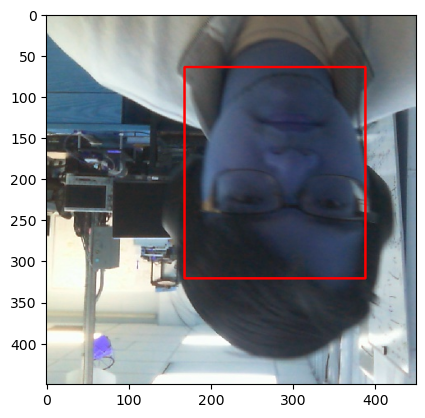

In [221]:
cv2.rectangle(image_augmented['image'],
                # Rescaled the coordinates to the cropped image size
                tuple(np.multiply(image_augmented['bboxes'][0][:2], [450,450]).astype(int)),
                tuple(np.multiply(image_augmented['bboxes'][0][2:], [450,450]).astype(int)),
                (255,0,0), 2)

plt.imshow(image_augmented['image'])

## 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
# DANGER ZONE
# The code below is used for quickly cleaning the augmented data (images + labels) from the train, val, and test folder in case I made some mistake in the augmmentation process
# Set enabled to True during the function call if you want to remove all the augmented data
def purge_aug_data(enabled=False):
    if enabled:
        for partition in ['train','test','val']:
            for image in os.listdir(os.path.join('aug_data',partition,'images')):
                os.remove(os.path.join('aug_data',partition,'images',image))

            for label in os.listdir(os.path.join('aug_data',partition,'labels')):
                os.remove(os.path.join('aug_data',partition,'labels',label))

purge_aug_data()


In [ ]:
augment_enabled = False
if augment_enabled:
    for partition in ['train','test','val']:
        for image in os.listdir(os.path.join('data',partition,'images')):
            img = cv2.imread(os.path.join('data',partition,'images',image))

            coords = [0, 0, 0.00001, 0.00001]

            # Assuming that the image file has a corresponding label file, the label path will be
            label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
            
            # There are some images without a label file (no face in the image). So we need to ensure to only load the existing json files
            if os.path.exists(label_path):
                with open(label_path) as f:
                    label = json.load(f)

                coords = [val for sublist in label['shapes'][0]['points'] for val in sublist]
                coords = list(np.divide(coords, [640,480,640,480]))

            try:
                # Create 60 augmented images for each image
                for x in range(60):
                    augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                    cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                    annotation = {}
                    annotation['image'] = image

                    if os.path.exists(label_path):
                        # When there is still a bounding box present after the augmentation
                        if len(augmented['bboxes']) == 0:
                            annotation['bboxes'] = [0,0,0,0]
                            annotation['class'] = 0
                        # When there is no face (bounding box) present after the augmentation
                        else:
                            annotation['bboxes'] = augmented['bboxes'][0]
                            annotation['class'] = 1
                    # When there was no bounding box in the original image (no json file in the data directory)
                    else:
                        annotation['bboxes'] = [0,0,0,0]
                        annotation['class'] = 0
                    
                    # Dump the image name, bboxes coordinates, and class into a corresponding output json file
                    with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)
                    

            except Exception as e:
                print(f"Error in {image}: {e}")
                continue

### 5.2 Load Augmented Images to Tensorflow Dataset

In [160]:
def load_and_preprocess_dataset(file_pattern, image_size=(120, 120)):
    ''' Function to load and preprocess the dataset 
    1. Load the image according to the file pattern
    2. Resize the image to 120,120 
    3. Normalize the pixel values to between 0 and 1
    
    the num_parallel_calls=tf.data.AUTOTUNE argument allows TensorFlow to automatically tune the number of parallel calls to the number of CPU cores'''
    return (tf.data.Dataset.list_files(file_pattern, shuffle=False)
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x: tf.image.resize(x, (120,120)), num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x: x / 255.0, num_parallel_calls=tf.data.AUTOTUNE))

In [161]:
train_images = load_and_preprocess_dataset('aug_data/train/images/*.jpg')
test_images  = load_and_preprocess_dataset('aug_data/test/images/*.jpg')
val_images   = load_and_preprocess_dataset('aug_data/val/images/*.jpg')

In [162]:
train_images.as_numpy_iterator().next()

array([[[0.9318628 , 0.9906863 , 0.9632353 ],
        [0.92401963, 0.98284316, 0.9642157 ],
        [0.88057595, 0.9393995 , 0.9276348 ],
        ...,
        [0.93210787, 0.94779414, 0.89240193],
        [0.8805147 , 0.9118872 , 0.85992646],
        [0.4648897 , 0.4963848 , 0.47132352]],

       [[0.94264704, 0.9936274 , 0.96617645],
        [0.9268995 , 0.985723  , 0.96697307],
        [0.8877451 , 0.95098037, 0.9377451 ],
        ...,
        [0.93063724, 0.9463235 , 0.8875    ],
        [0.88186276, 0.9122549 , 0.8686274 ],
        [0.49264705, 0.5181373 , 0.49607843]],

       [[0.95490193, 0.9980392 , 0.9745098 ],
        [0.9436275 , 0.99558824, 0.96911764],
        [0.9078431 , 0.9745098 , 0.95098037],
        ...,
        [0.9189951 , 0.93468136, 0.87585783],
        [0.8869485 , 0.90949756, 0.8623162 ],
        [0.4870098 , 0.51740193, 0.49289215]],

       ...,

       [[0.952451  , 0.99558824, 0.97205883],
        [0.9372549 , 0.9882353 , 0.9607843 ],
        [0.9264093 , 0

## 6. Prepare Labels

### 6.2 Label Loading Function

In [163]:
def load_labels(label_path):
    ''' Function to extract the class and bounding box from the label path '''
    
    # label_path = tf.data.Dataset.list_files(label_pattern, shuffle=False)

    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bboxes']


In [164]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json',shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json',shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json',shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

train_labels.as_numpy_iterator().next()
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3054, 0.3484, 0.738 , 0.863 ], dtype=float16))

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [165]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) 

(1500, 1500, 180, 180, 180, 180)

In [82]:
type(train_images), type(train_labels), type(test_images), type(test_labels), type(val_images), type(val_labels)    

(tensorflow.python.data.ops.dataset_ops.ParallelMapDataset,
 tensorflow.python.data.ops.dataset_ops.MapDataset,
 tensorflow.python.data.ops.dataset_ops.ParallelMapDataset,
 tensorflow.python.data.ops.dataset_ops.MapDataset,
 tensorflow.python.data.ops.dataset_ops.ParallelMapDataset,
 tensorflow.python.data.ops.dataset_ops.MapDataset)

### 7.2 Create the final datasets

In [169]:
train = tf.data.Dataset.zip((train_images, train_labels))

# Shuffle the data, batch the data up in batches of 8, then pre-fetch 4 batches
train = train.shuffle(train.cardinality())
train = train.batch(8)
train = train.prefetch(4)

In [171]:
val = tf.data.Dataset.zip((val_images, val_labels))

# Shuffle the data, batch the data up in batches of 8, then pre-fetch 4 batches
val = val.shuffle(val.cardinality()).batch(8).prefetch(4)

In [172]:
test = tf.data.Dataset.zip((test_images, test_labels))

# Shuffle the data, batch the data up in batches of 8, then pre-fetch 4 batches
test = test.shuffle(test.cardinality()).batch(8).prefetch(4)

In [176]:
print(train.as_numpy_iterator().next()[0].shape)
print(train.as_numpy_iterator().next()[1])

(8, 120, 120, 3)
(array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1]], dtype=uint8), array([[0.09564, 0.0828 , 0.6323 , 0.6655 ],
       [0.2048 , 0.3008 , 0.7476 , 0.8833 ],
       [0.526  , 0.3252 , 1.     , 0.9077 ],
       [0.5283 , 0.12103, 1.     , 0.7036 ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.191  , 0.1335 , 0.595  , 0.62   ],
       [0.746  , 0.3184 , 1.     , 0.901  ]], dtype=float16))


### 7.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()


```res``` is a tuple that contains the 8 images in the first element, 8 classes in the second element, and 8 bounding box coordination sets in the final element.

Every time the following code block is run, a new sample is generated

In [254]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


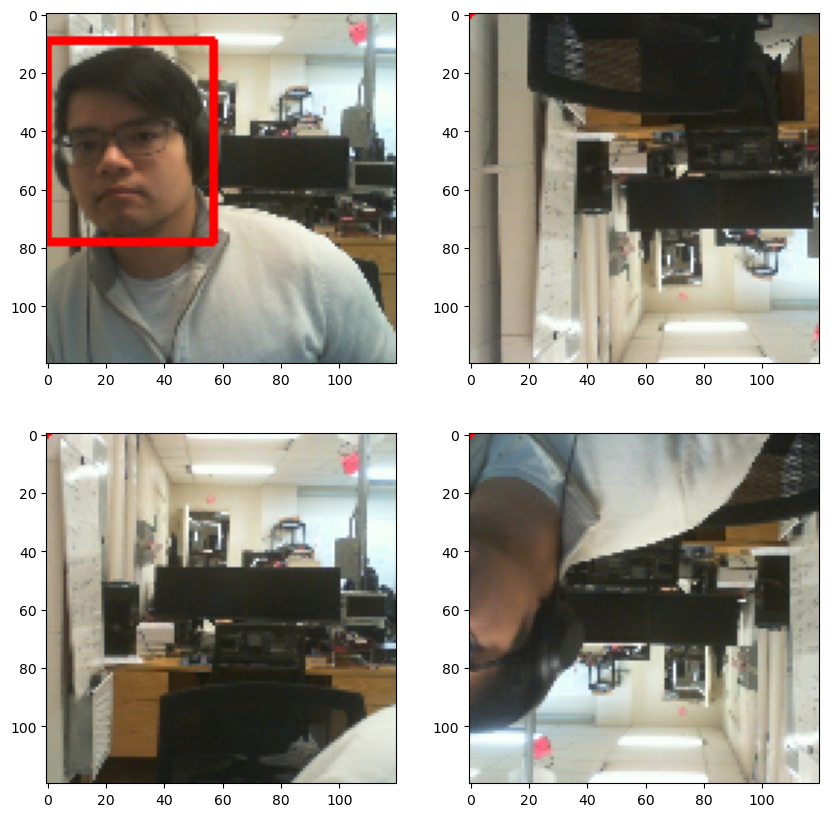

In [255]:
nrows = 2
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for idx in range(4):
    sample_image = np.array(res[0][idx])                # Had to further convert this into a writable numpy array
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                    (255,0,0), 2)

    ax[idx%2][idx//2].imshow(sample_image)

# BUILD AND TRAIN THE DEEP LEARNING MODEL

## 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [258]:
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16
Disregard the top layer of the VGG16 algorithm since we have a customized classification + regression output instead of the VGG16 classification output

In [259]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

### 8.3 Build upon the base VGG16

In [268]:
def build_model():
    ''' Function to build the face tracker model '''
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # The classification head takes the VGG-transformed representation and perform binary classification (face/no-face)
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # The regression head takes the VGG-transformed representation and perform regression of bounding box coordinates
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Build and test the model prediction (before training)

In [270]:
facetracker = build_model()
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_9[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [271]:
X, y = train.as_numpy_iterator().next()
X.shape, y[0].shape, y[1].shape

((8, 120, 120, 3), (8, 1), (8, 4))

In [272]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 5s 5s/step


In [276]:
classes, coords

(array([[0.66269445],
        [0.5806244 ],
        [0.5017996 ],
        [0.67899376],
        [0.6451495 ],
        [0.5779497 ],
        [0.58767015],
        [0.6531676 ]], dtype=float32),
 array([[0.3851679 , 0.49783197, 0.728199  , 0.60160094],
        [0.3306309 , 0.43041673, 0.77908754, 0.586426  ],
        [0.3028582 , 0.5397455 , 0.6905399 , 0.65089947],
        [0.37312368, 0.5141241 , 0.7696433 , 0.5847551 ],
        [0.3753779 , 0.49894756, 0.7487506 , 0.6330345 ],
        [0.31246334, 0.46628106, 0.7601893 , 0.59925175],
        [0.31603682, 0.5044026 , 0.6770888 , 0.644399  ],
        [0.38401347, 0.49959782, 0.7573473 , 0.62355673]], dtype=float32))

In [290]:
y[1]

array([[0.     , 0.06235, 0.391  , 0.559  ],
       [0.1343 , 0.1863 , 0.697  , 0.789  ],
       [0.5825 , 0.1974 , 1.     , 0.764  ],
       [0.     , 0.4412 , 0.2734 , 0.9375 ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.072  , 0.4014 , 0.5747 , 0.938  ],
       [0.1448 , 0.2517 , 0.6533 , 0.8022 ],
       [0.     , 0.     , 0.     , 0.     ]], dtype=float16)

## 9. Define Losses and Optimizers

### 9.1 Define Optimizer and Learning Rate

In [284]:
# The number of batches per epoch (# train samples / batch size)
batches_per_epoch = train.cardinality().numpy()
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam((learning_rate=0.0001), decay=lr_decay)

0.33333333333333326

### 9.2 Create the Loss Metrics (Classification + Localization)

In [304]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [305]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test the Loss Metrics
We can then use the localization loss to determine how wrong the initial prediction (calculated in the previous section) is

In [ ]:
localization_loss(y[1], coords).numpy()
regressloss(y[1], coords).numpy()

3.1611009

In [310]:
classloss(y[0],classes).numpy()

0.65082735